In [2]:
%load_ext lab_black

In [3]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, DayLocator, MonthLocator

In [4]:
def plot_time_series(df, xlabel, ylabel, **kwargs):
    fig, ax = plt.subplots(figsize=(15, 6))

    ax.plot(
        df[xlabel],
        df[ylabel],
        color="tab:blue",
        label="transacted value",
    )

    ax.set(xlabel=xlabel, ylabel=ylabel, **kwargs)
    ax.grid(True)

    ax.xaxis.set_minor_locator(MonthLocator())

    fig.autofmt_xdate()

### Data Load

In [5]:
# Data Load
credit_card_data_path = os.path.join(os.getcwd(), "2. Excel_Credit_Card_Data.xlsx")

cc = pd.ExcelFile(credit_card_data_path)

col_names = [
    "TRANSACTION_DATE",
    "COMPANY",
    "MERCHANT",
    "TRANSACTION_COUNT",
    "TRANSACTED_VALUE",
]
df_daily = cc.parse(cc.sheet_names[0], names=col_names, usecols="A:E")

# Remove rows with just NaNs.
df_daily = df_daily[~(df_daily.isnull().sum(axis=1) == df_daily.shape[1])].reset_index(
    drop=True
)

col_names_norm = ["TRANSACTION_DATE", "NORMALIZATION_FACTOR"]
df_norm = cc.parse(cc.sheet_names[1], names=col_names_norm, usecols="A:B")

# Remove rows with just NaNs. (wrong parsing of Excel)
df_norm = df_norm[~(df_norm.isnull().sum(axis=1) == df_norm.shape[1])].reset_index(
    drop=True
)

### First sanity checks on the data.

In [6]:
# decaptilize, easier to work with.
df_daily.columns = df_daily.columns.str.lower()
df_norm.columns = df_norm.columns.str.lower()

In [7]:
# df_daily["company"].value_counts()
# df_daily["merchant"].value_counts()
# df_daily.groupby(["merchant"])["transaction_date"].agg(["min", "max"])

# =>  KFC/PH and TB/PH/KFC have lower amounts of dates than the rest.  -- probabily data error
# =>  data ranges 2012-06-21 to	2014-12-31 and seems to span for all the companies the same time-period

In [8]:
df_daily

,transaction_date,company,merchant,transaction_count,transacted_value
0,2012-06-21,Arbys,Arbys,3825.0,37892.475210
1,2012-06-22,Arbys,Arbys,3884.0,39552.138593
2,2012-06-23,Arbys,Arbys,3113.0,36953.707410
3,2012-06-24,Arbys,Arbys,3457.0,38104.701896
4,2012-06-25,Arbys,Arbys,3480.0,34012.726002
...,...,...,...,...,...
35786,2014-12-27,YUM-USAA,Taco Bell,27656.0,295908.427733
35787,2014-12-28,YUM-USAA,Taco Bell,30321.0,315273.695856
35788,2014-12-29,YUM-USAA,Taco Bell,32792.0,312382.607954
35789,2014-12-30,YUM-USAA,Taco Bell,31731.0,298175.963026


### Normalization Factor Data
- Quick Checks & Data Cleaning
- Understand from data what is Normalization Factor

In [9]:
assert df_norm["transaction_date"].drop_duplicates().shape[0] == df_norm.shape[0], "transaction_date is not the key of df_norm"

AssertionError: transaction_date is not the key of df_norm

In [10]:
print("Duplicated rows:")
df_norm[df_norm["transaction_date"].duplicated(keep=False)]
# => Two values per single transaction date, not too far apart. I will take an average here

Duplicated rows:


,transaction_date,normalization_factor
832,2014-10-26,11354385.0
833,2014-10-26,11295760.0
834,2014-10-27,11756101.0
835,2014-10-27,11797289.0
836,2014-10-28,11410026.0
837,2014-10-28,11443158.0
838,2014-10-29,11135959.0
839,2014-10-29,11158306.0
840,2014-10-30,10856124.0
841,2014-10-30,10827402.0


In [11]:
df_norm = df_norm.groupby(["transaction_date"], as_index=False)[
    "normalization_factor"
].mean()

In [12]:
assert (
    df_norm["transaction_date"].drop_duplicates().shape[0] == df_norm.shape[0]
), "transaction_date is not the key of df_norm"

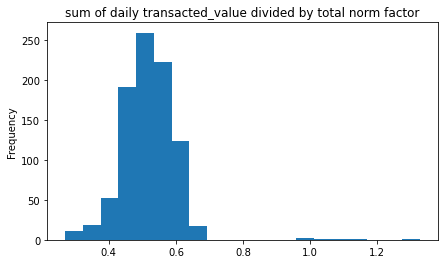

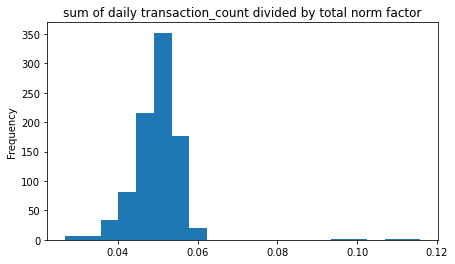

In [13]:
# Understand the Normalization Factor better.
# Check whether it is the sum of all transactions of quick chain restaurant or the whole US market
df_total = (
    df_daily.groupby("transaction_date")[["transacted_value", "transaction_count"]]
    .sum()
    .join(df_norm.set_index("transaction_date"))
    .assign(
        calculated_sum_over_total_given=lambda d: d["transacted_value"]
        / d["normalization_factor"],
        calculated_count_over_total_given=lambda d: d["transaction_count"]
        / d["normalization_factor"],
    )
    .reset_index()
)
fig, ax = plt.subplots(figsize=(7, 4))
df_total["calculated_sum_over_total_given"].plot.hist(ax=ax, bins=20)
_ = ax.set(title="sum of daily transacted_value divided by total norm factor")

fig, ax2 = plt.subplots(figsize=(7, 4))
df_total["calculated_count_over_total_given"].plot.hist(ax=ax2, bins=20)
_ = ax2.set(title="sum of daily transaction_count divided by total norm factor")

# => Seems that the normalization factor is the transcctions counts (as value > 1.0 exist in fist plot)
# => The Normalization factor is way large than the sum of counts in quick restaurants => We have a subsample of data.
#
# => Potentially it would be better to normalize by transactions VALUE rather than COUNT!
#    NEXT: See if the avearge price changes over time.
#    If it changes we could adjust that later by multiplying by average transanction size.

In [14]:
# Check missing dates of df_norm
df_time = pd.DataFrame(
    {
        "date": pd.date_range(
            df_norm["transaction_date"].min(), df_norm["transaction_date"].max()
        )
    }
)

df_norm = df_time.merge(
    df_norm, how="left", left_on="date", right_on="transaction_date"
)
print("Missing dates in df_norm:")
df_norm[df_norm["transaction_date"].isnull()]

Missing dates in df_norm:


,date,transaction_date,normalization_factor
832,2014-10-01,NaT,NaN
833,2014-10-02,NaT,NaN
834,2014-10-03,NaT,NaN
835,2014-10-04,NaT,NaN
836,2014-10-05,NaT,NaN
837,2014-10-06,NaT,NaN
838,2014-10-07,NaT,NaN
839,2014-10-08,NaT,NaN
840,2014-10-09,NaT,NaN
841,2014-10-10,NaT,NaN


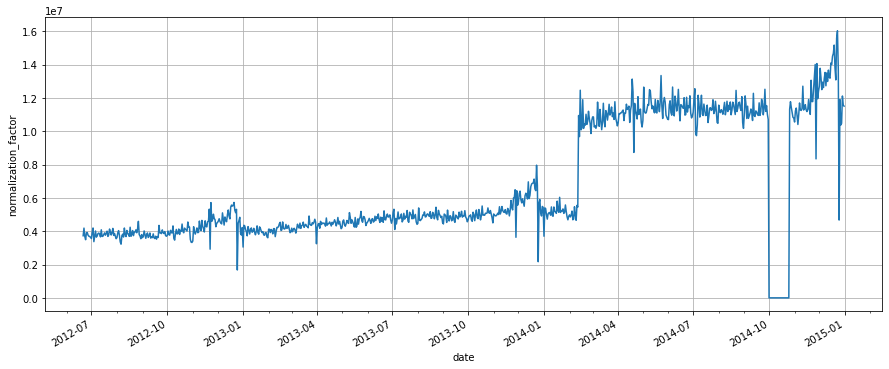

In [15]:
plot_time_series(
    df_norm.assign(normalization_factor=lambda d: d["normalization_factor"].fillna(0)),
    "date",
    "normalization_factor",
)

# => Large spike in 2014/02 of data # => discontinuity at 12/02/2014
#    - Seems that the data provider changed it logic with the data.
#    - We no longer have the same fix US customers across the time. (That could be generally True across the data)
# => Couple of days with way lower transanctions -> potentially christmas, national holiday days etc.
# => No data between 30/09/2014 and 26/10/2014

## daily_data

In [16]:
# Fix also the duplication in df_daily
df_daily = df_daily.groupby(
    ["merchant", "transaction_date", "company"], as_index=False
)[["transaction_count", "transacted_value"]].mean()

assert (
    df_daily.drop_duplicates(["merchant", "transaction_date"]).shape[0]
    == df_daily.shape[0]
)

In [17]:
# See if there are missing dates in the df_daily
df_merchants = pd.DataFrame({"merchant": df_daily["merchant"].unique().tolist()})
df_ = df_time.merge(df_merchants, how="cross")

df_daily_clean = df_.merge(
    df_daily,
    how="left",
    left_on=["date", "merchant"],
    right_on=["transaction_date", "merchant"],
)
df_daily_clean["year_month"] = df_daily_clean["date"].dt.strftime("%Y_%m")
df_daily_clean["year"] = df_daily_clean["date"].dt.year
df_daily_clean["month"] = df_daily_clean["date"].dt.month

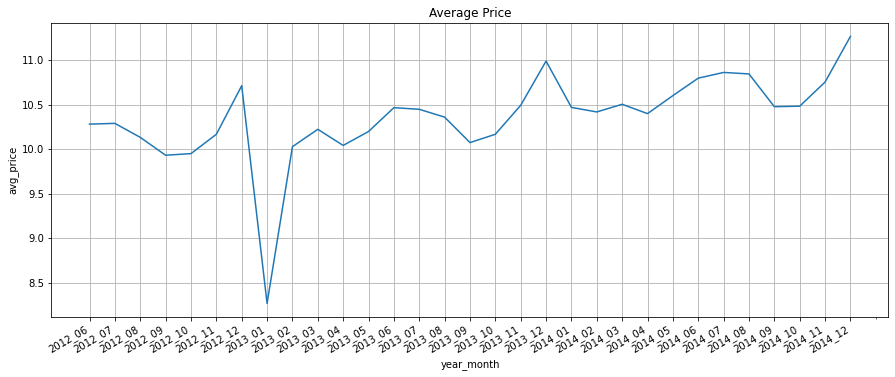

In [18]:
# Quick check if average price varies across the years
df_avg_price = (
    df_daily_clean.groupby(["year_month"])[["transaction_count", "transacted_value"]]
    .sum()
    .assign(avg_price=lambda d: d["transacted_value"] / d["transaction_count"])
)

plot_time_series(
    df_avg_price.reset_index(), "year_month", "avg_price", **{"title": "Average Price"}
)
# => There seems to be a positive trend in average price => Inflation
# => 2013_01 some data problem..

In [19]:
MERCHANT_SELECTION = [
    "McDonalds",
    "Burger King",
    "Wendys",
    "Pizza Hut",
    "Dominos Pizza",
    "Papa Johns",
]

We are interested in how the 3 burger chains (McDonalds/Burger King/Wendy’s) and 3 pizza chains (Pizza Hut/Domino’s Pizza/Papa Johns) are doing as of 2014 Q4. 

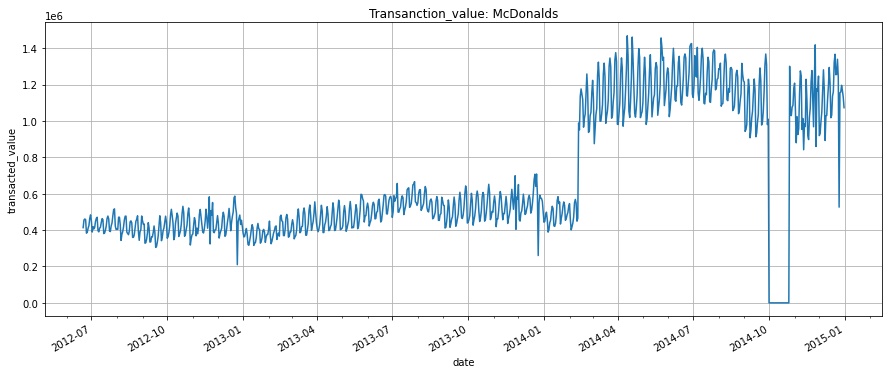

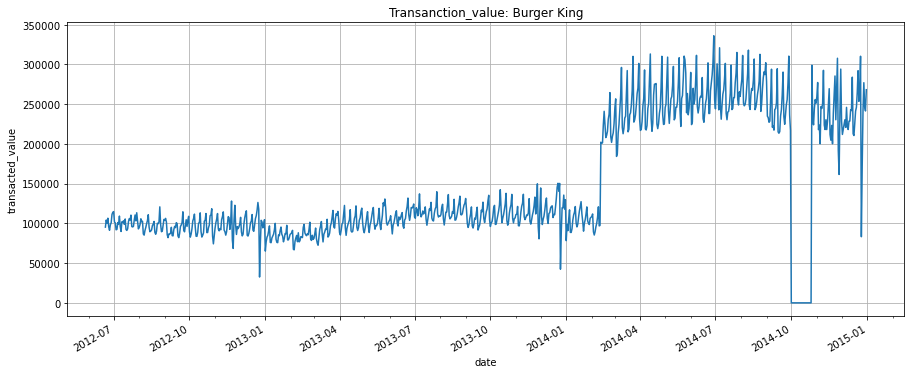

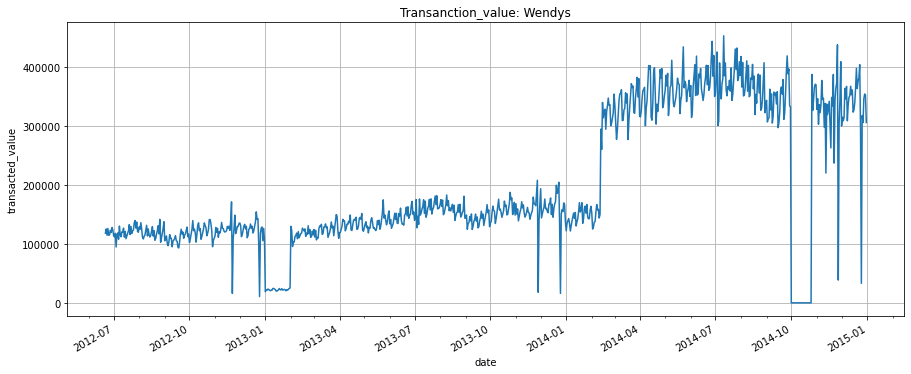

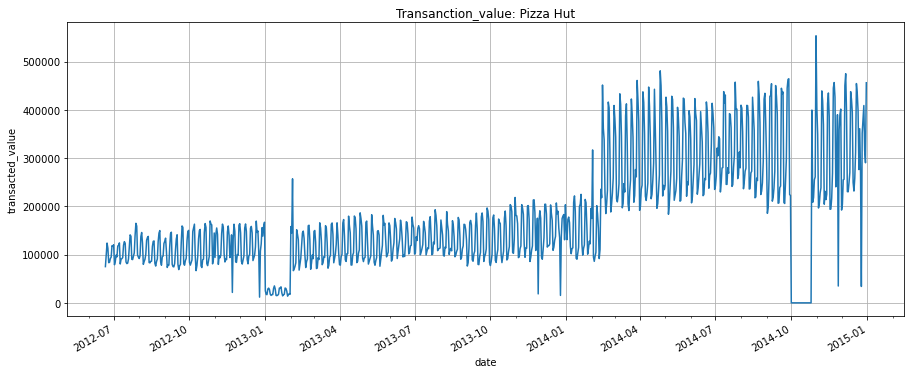

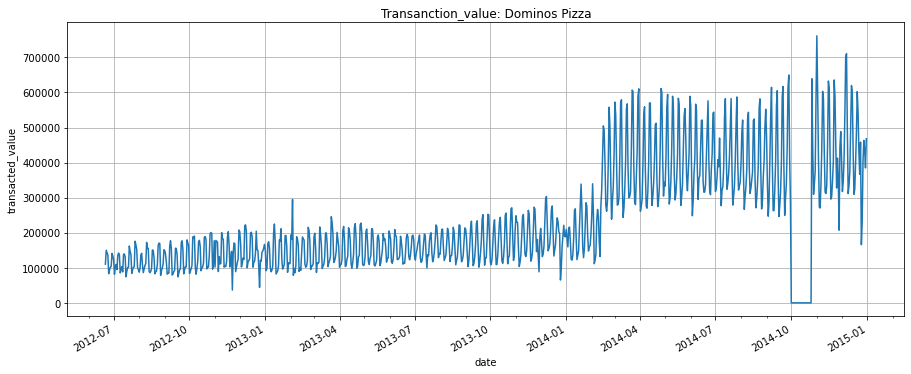

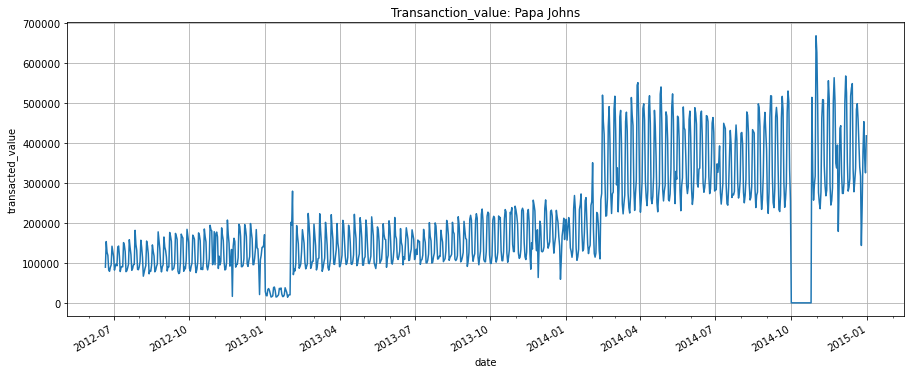

In [20]:
for merchant in MERCHANT_SELECTION:
    df_plot = df_daily_clean[df_daily_clean["merchant"] == merchant]
    plot_time_series(
        df_plot.fillna(0),
        "date",
        "transacted_value",
        **{"title": f"Transanction_value: {merchant}"},
    )

# => no more missing data exists for these, apart from the ones perviously discovered 30/09/2014 and 26/10/2014
# => ANOMALITY for Wendys/Pizza Hut and Papa Johns in 2013-01 be CAREFULL when using that data... (y-o-y or so)
#   => Potentially missing data?
#   => Rather unlikely that is some January Effect, as it is not visible in other comparies and in 2014-01!
# => Dec, 2013, 2014 sharp drops for some date. Probably restaraunts are closed for some days.

### Fill the Missing values in the both data set
---

- A good quick predictor for missing values is to take the mean of transactions for the time period 14 day before and 14 days after of the missing data. 
- Why 14?
   - Two weeks we have weekly seasonality. Hence it should be a multiple of 7. why 2 weeks? as less given weeks variance.

In [21]:
# df_daily - Fill in the missing values
# Use mean from -14day and +14days from that period

df_daily_clean["indicator_for_stats"] = (
    df_daily_clean["date"] >= pd.to_datetime("2014-10-01") - pd.DateOffset(14)
) & (df_daily_clean["date"] <= pd.to_datetime("2014-10-25") + pd.DateOffset(14))

df_stats = df_daily_clean[df_daily_clean["indicator_for_stats"]].dropna()
df_stats = (
    df_stats.groupby("merchant")[["transacted_value", "transaction_count"]]
    .mean()
    .reset_index()
    .rename(
        columns={
            "transacted_value": "transacted_value_mean",
            "transaction_count": "transaction_count_mean",
        }
    )
)

df_daily_clean = df_daily_clean.merge(df_stats, on="merchant")
df_daily_clean["transacted_value"] = df_daily_clean["transacted_value"].fillna(
    df_daily_clean["transacted_value_mean"]
)
df_daily_clean["transaction_count"] = df_daily_clean["transaction_count"].fillna(
    df_daily_clean["transaction_count_mean"]
)

In [22]:
# df_norm Fill in the missing values
# Use mean from -14day and +14days from that period

df_norm["indicator_for_stats"] = (
    df_norm["date"] >= pd.to_datetime("2014-10-01") - pd.DateOffset(14)
) & (df_norm["date"] <= pd.to_datetime("2014-10-25") + pd.DateOffset(14))

df_mean = df_norm[df_norm["indicator_for_stats"]].dropna()

df_norm["normalization_factor"] = df_norm["normalization_factor"].fillna(
    df_mean["normalization_factor"].mean()
)

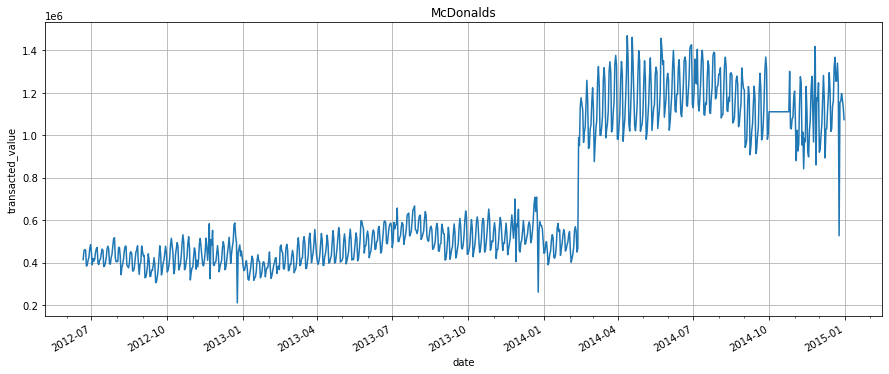

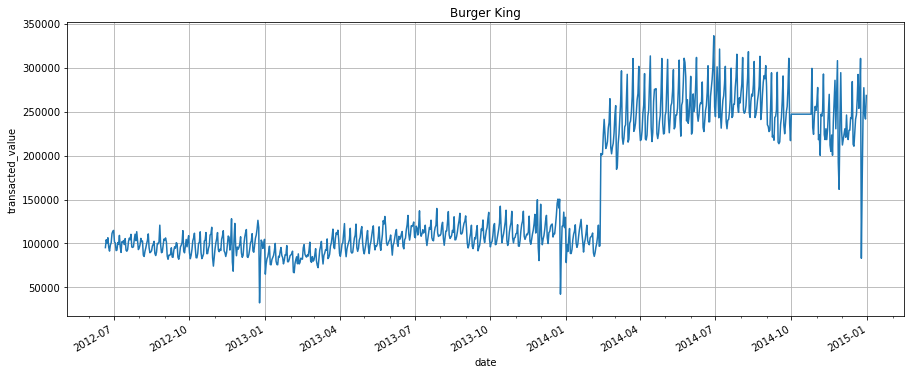

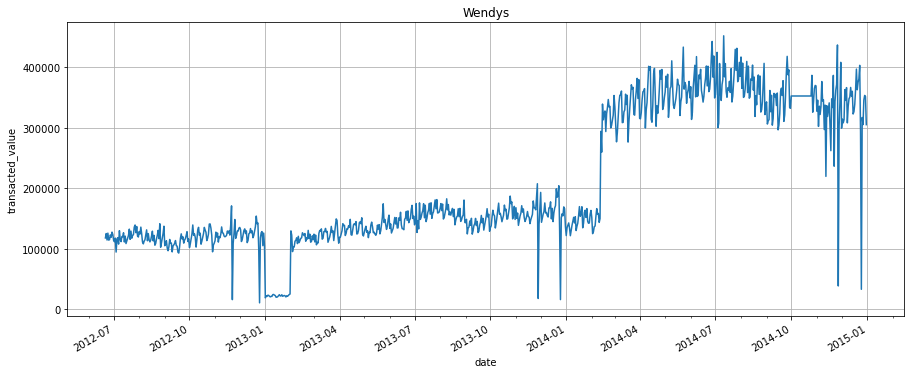

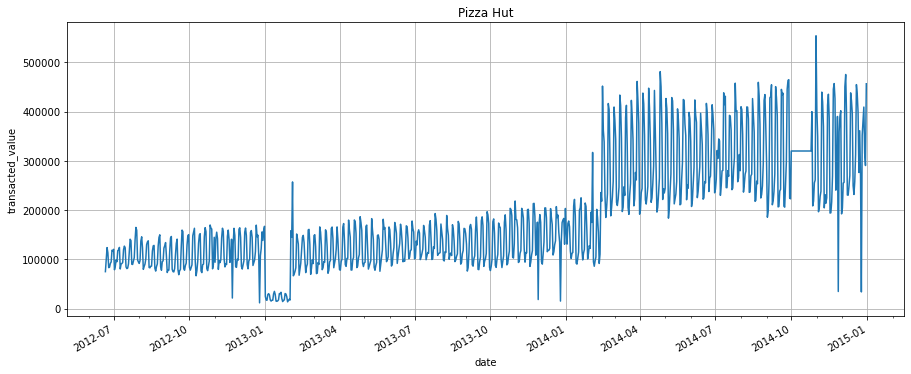

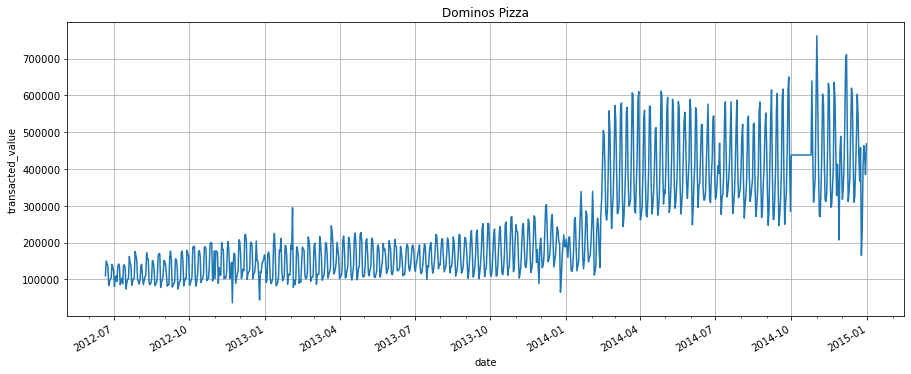

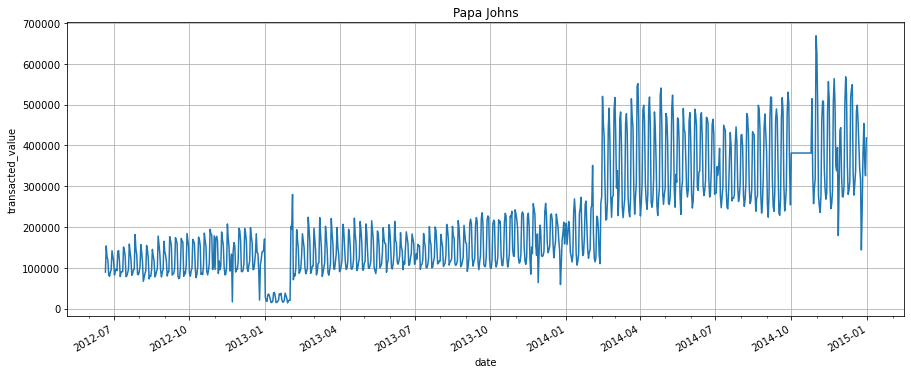

In [23]:
# CHECK
for merchant in MERCHANT_SELECTION:
    df_plot = df_daily_clean[df_daily_clean["merchant"] == merchant]
    plot_time_series(
        df_plot.fillna(0), "date", "transacted_value", **{"title": merchant}
    )

### Merge the dataset and compute the normalization factor adjusted for rising average prices.
---

In [24]:
## Compute the market transanctions-value as another normalizing factor
df_trans_sum = (
    df_daily_clean.groupby(["date"], as_index=False)[
        ["transacted_value", "transaction_count"]
    ]
    .sum()
    .assign(avg_price_market=lambda d: d["transacted_value"] / d["transaction_count"])
    .rename(columns={"transacted_value": "transacted_value_market"})
    .drop(columns=["transaction_count"])
)

# Merge the data
df_daily_selected = (
    df_daily_clean[df_daily_clean["merchant"].isin(MERCHANT_SELECTION)]
    .drop(
        columns=[
            "indicator_for_stats",
            "transacted_value_mean",
            "transaction_count_mean",
        ]
    )
    .merge(df_norm[["date", "normalization_factor"]], on=["date"])
    .merge(df_trans_sum, how="left", on=["date"])
)

df_daily_selected["normalization_factor_transaction_value"] = (
    df_daily_selected["normalization_factor"] * df_daily_selected["avg_price_market"]
)

In [25]:
df_daily_selected[df_daily_selected["merchant"] == "McDonalds"]

,date,merchant,transaction_date,company,transaction_count,transacted_value,year_month,year,month,normalization_factor,transacted_value_market,avg_price_market,normalization_factor_transaction_value
2,2012-06-21,McDonalds,2012-06-21,MCD-USAA,56662.0,4.136718e+05,2012_06,2012,6,3728765.0,1.987865e+06,9.732574,3.629048e+07
8,2012-06-22,McDonalds,2012-06-22,MCD-USAA,59521.0,4.556815e+05,2012_06,2012,6,4186954.0,2.234420e+06,10.381271,4.346591e+07
14,2012-06-23,McDonalds,2012-06-23,MCD-USAA,54730.0,4.612457e+05,2012_06,2012,6,3685411.0,2.150341e+06,11.383669,4.195350e+07
20,2012-06-24,McDonalds,2012-06-24,MCD-USAA,54592.0,4.580269e+05,2012_06,2012,6,3491099.0,1.998377e+06,11.146267,3.891272e+07
26,2012-06-25,McDonalds,2012-06-25,MCD-USAA,52526.0,3.831620e+05,2012_06,2012,6,3915872.0,1.866004e+06,9.576192,3.749914e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5516,2014-12-27,McDonalds,2014-12-27,MCD-USAA,124698.0,1.158948e+06,2014_12,2014,12,10376498.0,5.902013e+06,13.083342,1.357593e+08
5522,2014-12-28,McDonalds,2014-12-28,MCD-USAA,130594.0,1.196732e+06,2014_12,2014,12,10479593.0,5.624067e+06,12.978177,1.360060e+08
5528,2014-12-29,McDonalds,2014-12-29,MCD-USAA,141297.0,1.167848e+06,2014_12,2014,12,12118902.0,6.215577e+06,11.621137,1.408354e+08
5534,2014-12-30,McDonalds,2014-12-30,MCD-USAA,139353.0,1.131268e+06,2014_12,2014,12,11571844.0,5.925591e+06,11.482791,1.328771e+08


## a.	Aggregate the sales by month

In [26]:
df_monthly = df_daily_selected.groupby(
    ["year_month", "year", "month", "merchant"], as_index=False
)[
    [
        "transaction_count",
        "transacted_value",
        "transacted_value_market",
        "normalization_factor",
        "normalization_factor_transaction_value",
    ]
].sum()

In [27]:
def plot_monthly_time_series(df, xlabel, ylabel, **kwargs):
    fig, ax = plt.subplots(figsize=(10, 4))

    ax.plot(
        df[xlabel],
        df[ylabel],
        color="tab:blue",
        label="transacted value",
    )

    ax.set(xlabel=xlabel, ylabel=ylabel, **kwargs)
    ax.tick_params(axis="x", labelrotation=90)
    ax.grid(True)

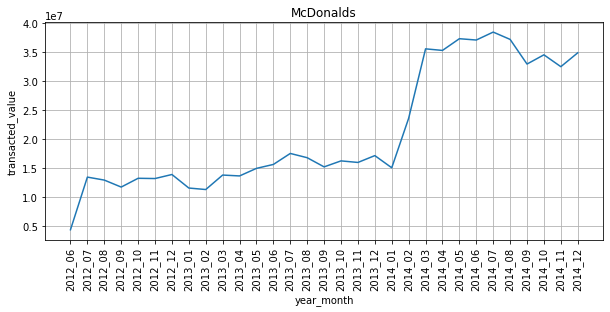

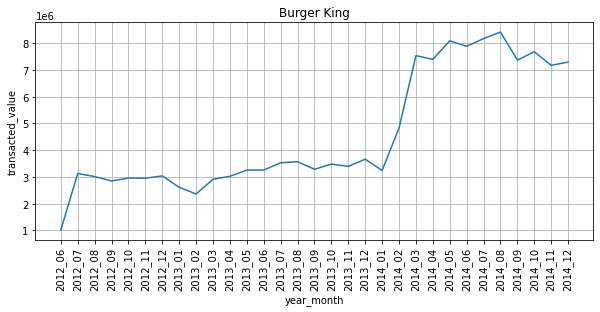

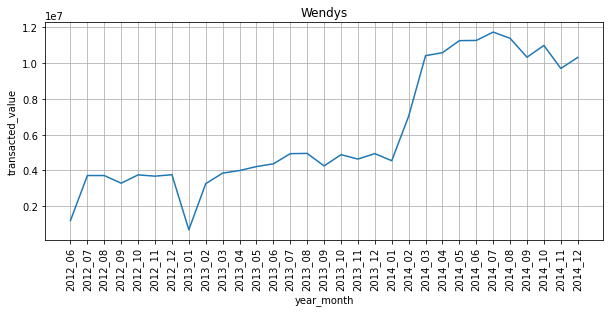

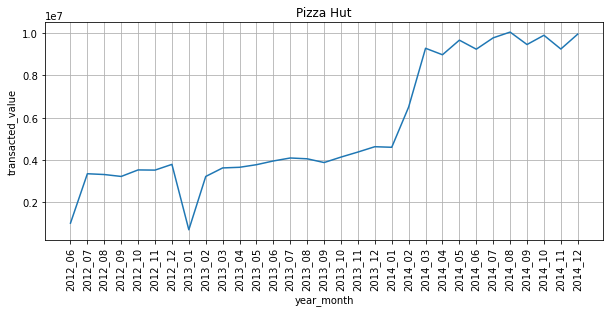

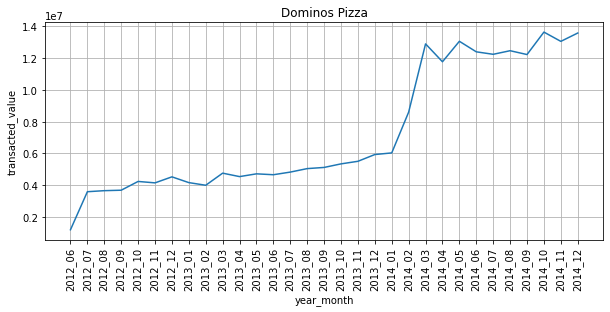

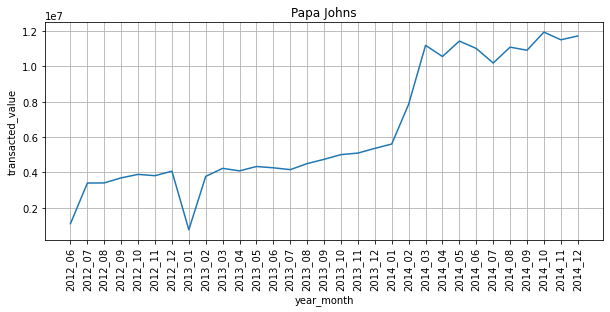

In [28]:
for merchant in MERCHANT_SELECTION:
    df_plot = df_monthly[df_monthly["merchant"] == merchant]

    plot_monthly_time_series(
        df_plot, "year_month", "transacted_value", **{"title": merchant}
    )

### b.	Compute a monthly sales figure adjusting for the panel size

- The data has varying panel size across time. Hence the increasing transaction_value data can be an effect of two things: 1) the data-provider adjusted the data-collection and suddenly the data has more Credit-Card users or 2) there is an increase of credit-card spending. Hence we should control the data by the panel size. We don't have the information then if the global market of quick restaruant is increasing but potentially we could get that from other sources.
- We can still compare how the quick restaurants are doing controlling by the panel size. Which basically means seeing how the are doing relative to each other.

We can define a year-over-year comparision metric based on:

### $\frac{\frac{SalesCompany_{tY}}{Sales Market_{tY}}}{\frac{SalesCompany_{tY-1}}{Sales Market_{tY-1}}}$

where, tY is a given year. This would give us a good indicator on how the company is doing.

Just as a side note, there are other option to consider, especially if we have more information from the data provider side. We might want to up-sample observations before 11/02/2014. That could be done either by 1) knowing how the data collection change, i.e. how many more customers does our sample consider, 2) estimating point 1. and doing the upsampling, here our strong assumption would be that this is the only discontinuity in the data. We could upsample by comparing the customer_transaction means before and after the discontinuity

In [29]:
df_monthly["monthly_market_share"] = (
    df_monthly["transacted_value"] / df_monthly["transacted_value_market"]
)

df_monthly["transacted_value_norm"] = (
    df_monthly["transacted_value"]
    / df_monthly["normalization_factor_transaction_value"]
)

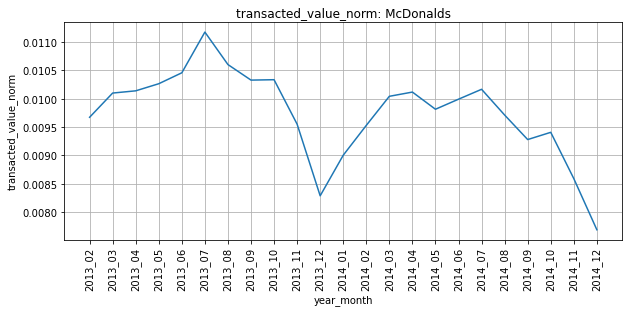

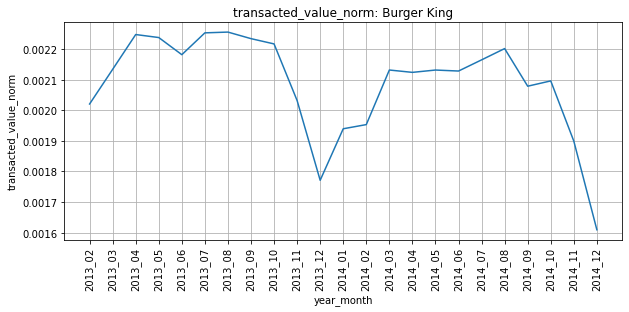

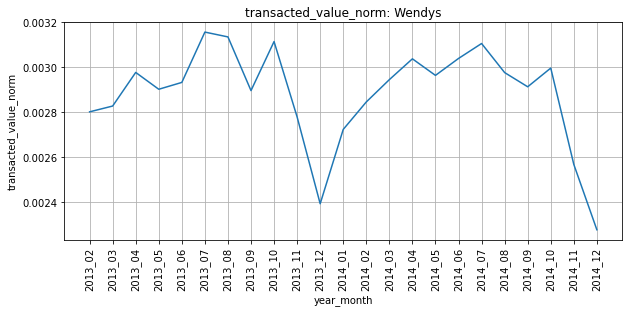

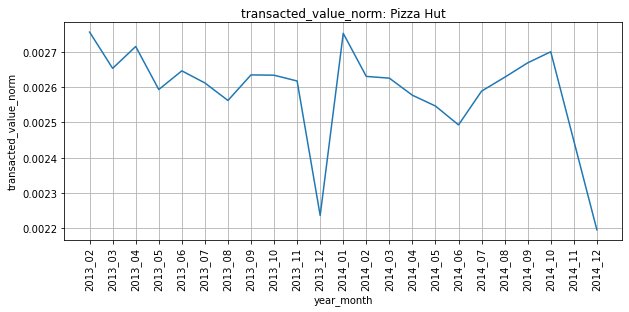

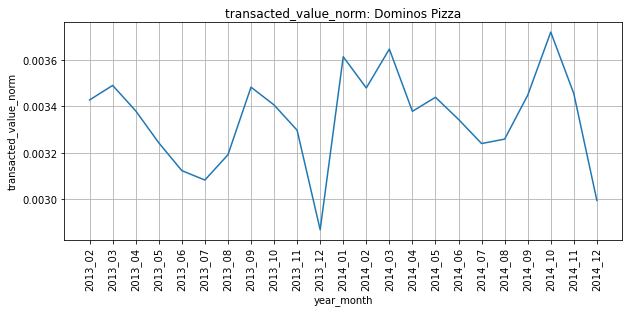

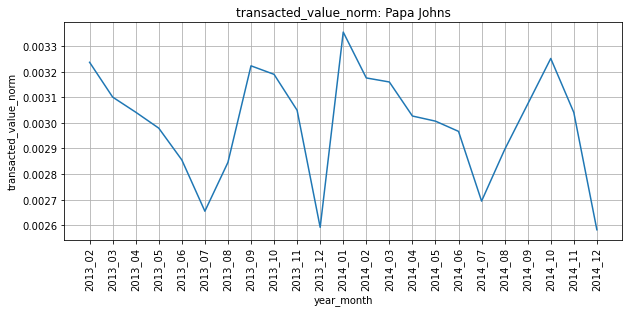

In [30]:
for merchant in MERCHANT_SELECTION:
    df_plot = df_monthly[
        (df_monthly["merchant"] == merchant) & (df_monthly["year_month"] > "2013_01")
    ]

    plot_monthly_time_series(
        df_plot,
        "year_month",
        "transacted_value_norm",
        **{"title": f"transacted_value_norm: {merchant}"},
    )

### c.	Compare the monthly YoY data

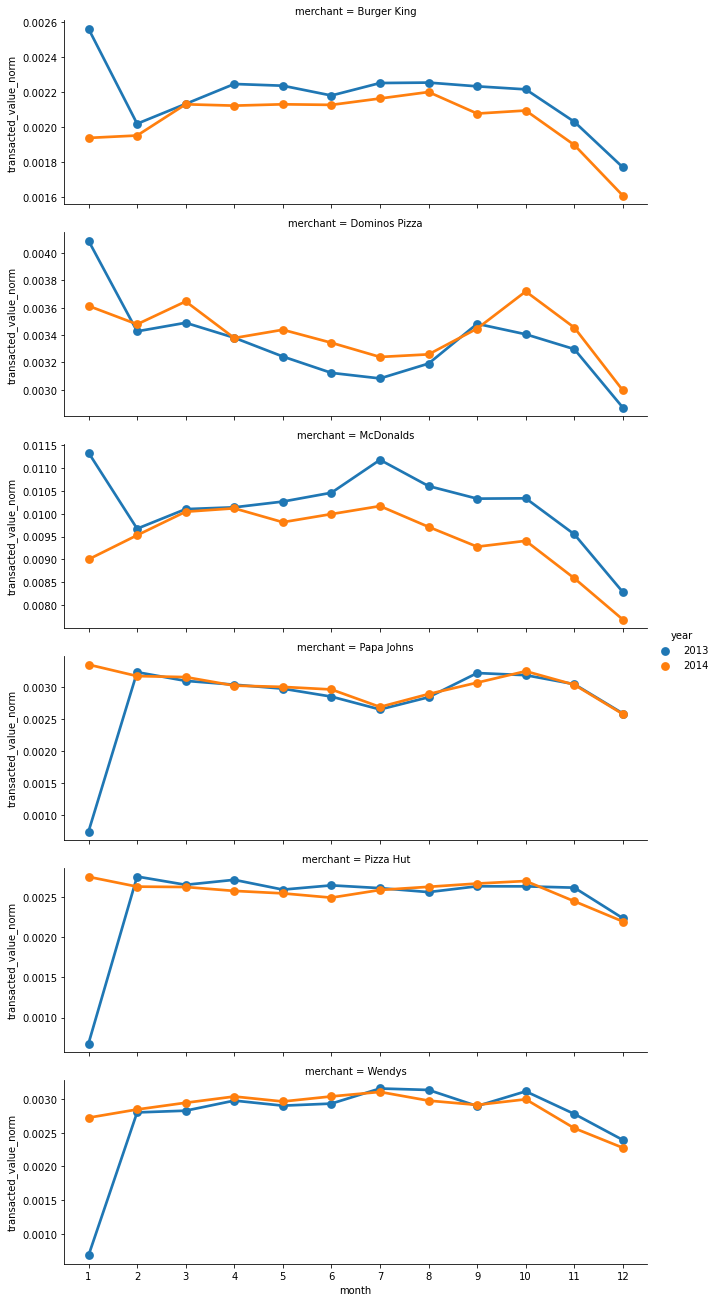

In [31]:
sns.catplot(
    x="month",
    y="transacted_value_norm",
    hue="year",
    row="merchant",
    data=df_monthly[df_monthly["year"] > 2012],
    kind="point",
    sharey=False,
    height=3,
    aspect=3,
)

#### y-o-y % increase

In [32]:
df_2013 = df_monthly[df_monthly["year"] == 2013].reset_index(drop=True)
df_2014 = df_monthly[df_monthly["year"] == 2014].reset_index(drop=True)

df_2013["key_2014"] = df_2013["year_month"].str.replace("2013", "2014")

df_plot = df_2014.merge(
    df_2013,
    left_on=["merchant", "year_month"],
    right_on=["merchant", "key_2014"],
    suffixes=("_2014", "_2013"),
)

df_plot["growth_y_o_y"] = (
    (df_plot["transacted_value_norm_2014"] / df_plot["transacted_value_norm_2013"]) - 1
) * 100

Text(0.5, 0.98, 'Growth, Year over Year in %')

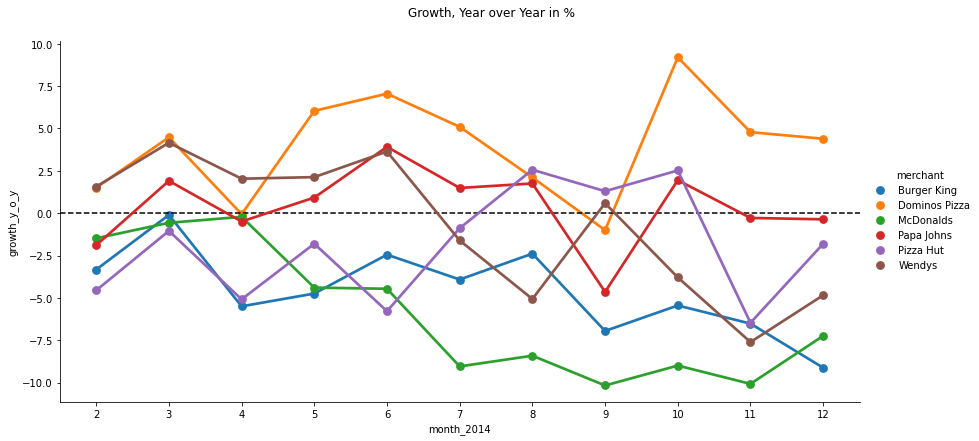

In [33]:
cp = sns.catplot(
    x="month_2014",
    y="growth_y_o_y",
    hue="merchant",
    data=df_plot[df_plot["month_2014"] > 1],
    kind="point",
    sharey=False,
    height=6,
    aspect=2,
)
cp.ax.axhline(0, linestyle="--", color="black")
cp.fig.subplots_adjust(top=0.9)  # adjust the Figure in rp
cp.fig.suptitle("Growth, Year over Year in %")

### Market Share
- This is compared to transactions values across all quick service restaurants.

In [34]:
# for merchant in MERCHANT_SELECTION:
#     df_plot = df_monthly[
#         (df_monthly["merchant"] == merchant) & (df_monthly["year_month"] > "2013_01")
#     ]

#     plot_monthly_time_series(
#         df_plot,
#         "year_month",
#         "monthly_market_share",
#         **{"title": f"Market Share of Credit Card Transactions: {merchant}"},
#     )

### Market Share Y-o-Y

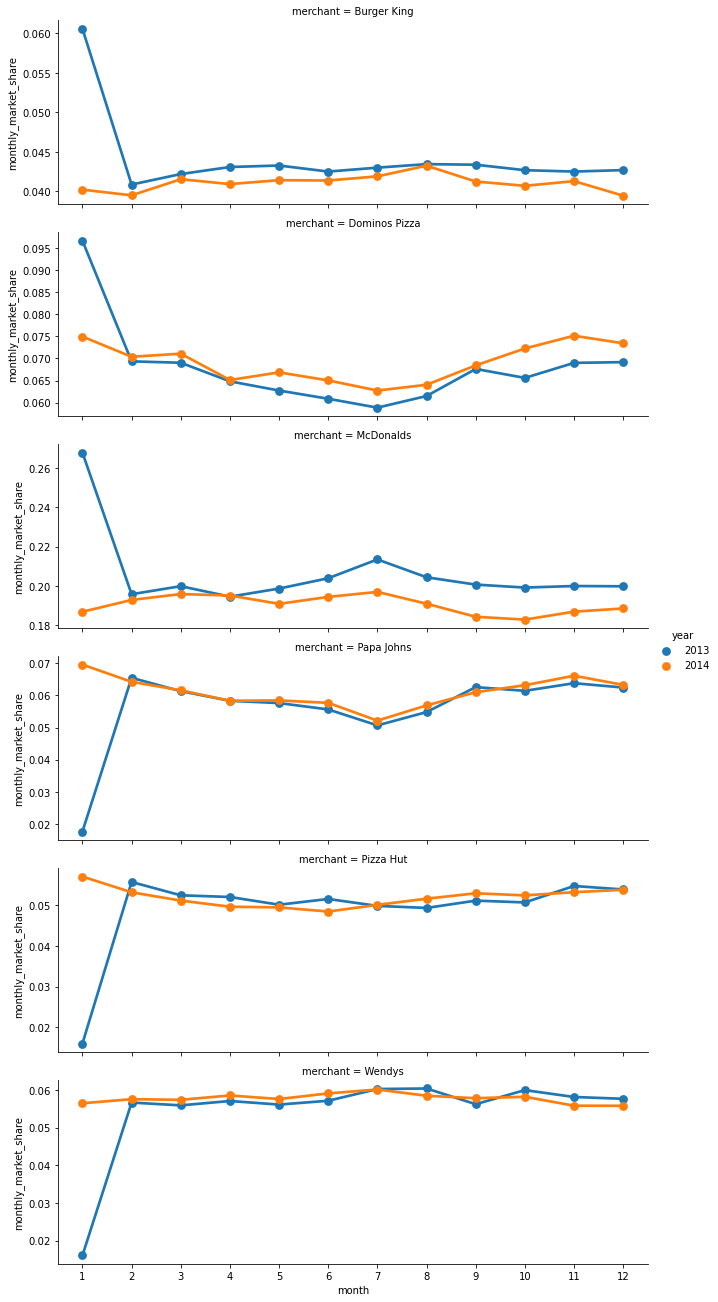

In [35]:
# That should be inline with other observations.
sns.catplot(
    x="month",
    y="monthly_market_share",
    hue="year",
    row="merchant",
    data=df_monthly[df_monthly["year"] > 2012],
    kind="point",
    sharey=False,
    height=3,
    aspect=3,
)
# Janaury have lower base level for some of the merchants. Comparision should be ignored.

### Pull together the credit card, survey, and URL tracking data.

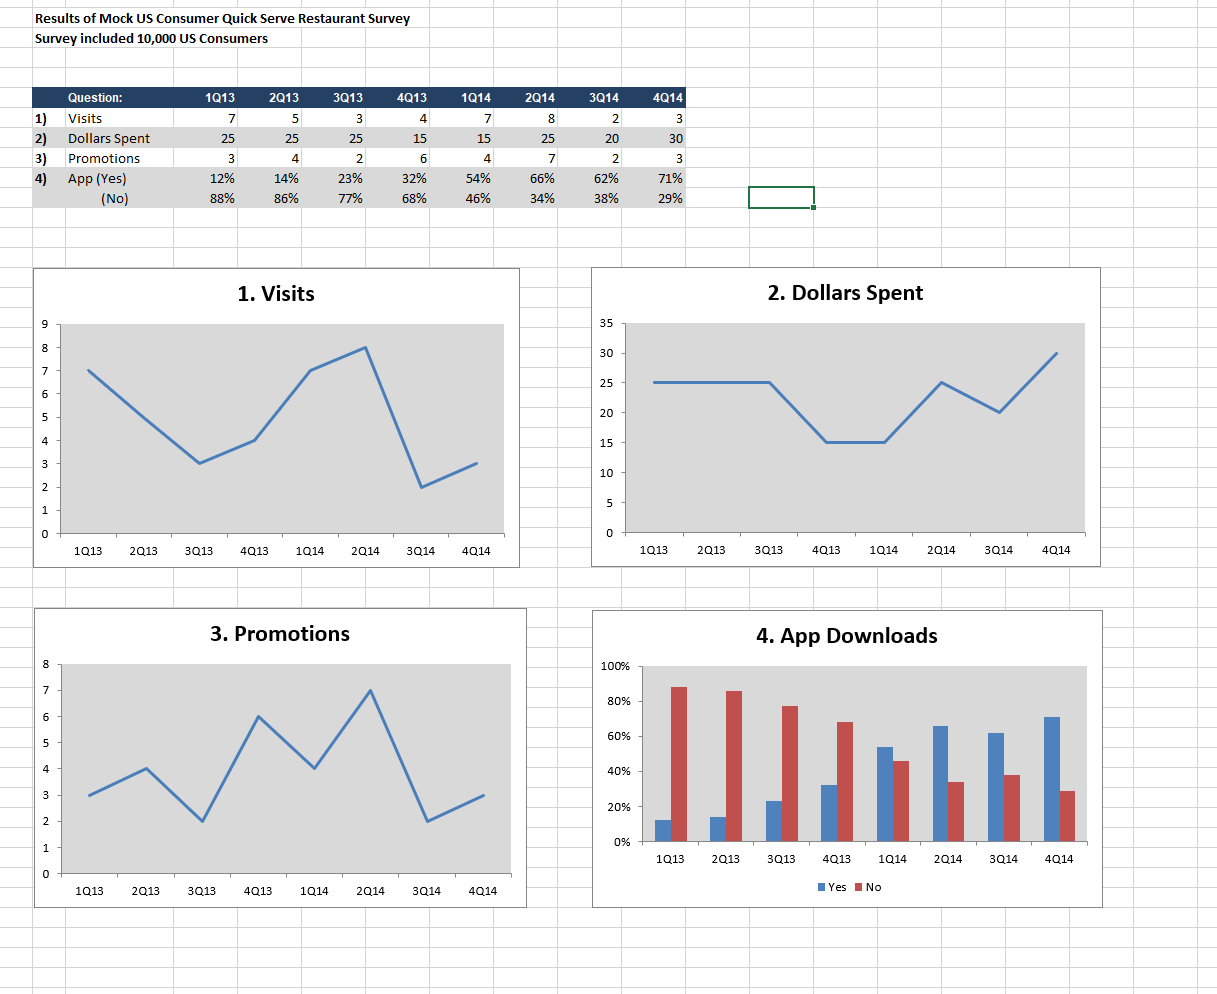

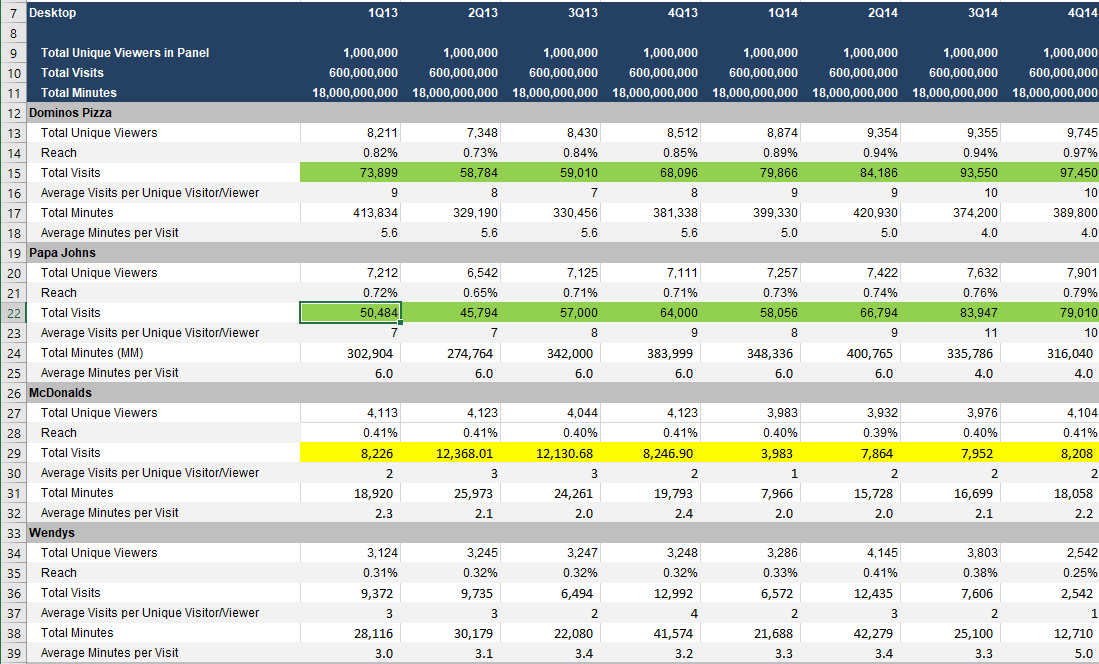

### 2. Can you formulate a thesis based on the data sets you have seen? / 3.	What trends can you determine based on the data?

#### Observations
- (From Survey) There is some seasonality in the visit to restaurants, Q3, Q4 has less visits than other Quaters.
- (From Survey) The reduction in visits in 3Q13, 4Q14 is way lower than in the previous year (2013). 
- (From Survey) App downloads substantially increased over time 
    - => promotions in apps,
    - => Paying through the app?
    - => Ordering through the app?
- (Credit Card Data) McDonald and Burger Kings is losing Market share and it's sales decrease from 2013->2014
- (Credit Card Data) Dominos Pizza Market share is increasing and sales also increased from 2013-> 2014
- (URL Data) McDonald Total visits also decrease from 2013->2014 (comparing the correspoding quarters).
- (URL Data) Dominos Pizza and Papa Johns visits increased from 2013->2014 (comparing the correspoding quarters).

#### 4.	What conclusions can you draw? / Thesis:

- (Short Summary) McDonald and Burger Kings sales is decreasing from 2013-> 2014, wherease there is an increase for Dominos Pizza and Papa Johns. Potentially there is a shift ongoing from burger chains to pizza chains.

### 5. What correlations can you draw between the data sets?
- Decreasing trend for McDonald in Sales is visible in Credit Card data and URL tracking
- Increasing trend foe Papa Johns in Sales is visible in Credit Card data and URL tracking


### 6. If you could ask another survey question, what would you ask?
- I would ask more granular questions. Split the questions by restuarant type (Pizza vs Burgers). That would help to see any shift if it happens.

### 7. If you could include another metric (Reach, Total Visits, etc.) in the URL track data, what would you track?
- If the website have some delivery option for these food-chain would like to know how many of the Viewers reach the order page.


### 8. What do you think are the pros/cons of the three data sets? / 9. If you could add an additional data source what would you request?

Credit Card
- This only contains transactions by Credit Card. One should understand how many transactions are done with other payment forms. One also needs to understand the temporal form of the Credit Card data, and what sample of credit card transactions does the data represent. Credit card usage across the population might change over time (there will be more users paying with credit cards rather than cash).  An good external source would be "% of transaction made by credit cards", time-series of number of credit-cards in a given country etc..

Survey
- It only contain 10_000 users surveyed. One needs to understand if any selection bias exists in this survey and how to counter that.

URL data
- Here our main assumption is that URL traffic is correlated with the number of sales at a particular restaurant. Many confouding effects could exist. 

Other data requests:
- Online Orders from these restaurants (Food delivery companies etc.) 
    - in 2014 that was not valid, but now it should have a effect.
- Number of restaurants for each chain

## Task 2: Integrating Alternative Data
----

### 1.	Write a brief commentary discussing whether you expect the transaction data from Task 1 to be better suited for predicting McDonald’s financial performance or its share price

- Transaction data would be better suited to predict McDonald's financial performance. Transactions should have a direct effect on revenues of the company. Then financial performance should have a effect on the stock price of McDonalds. So indirectly the Transaction data has effect on the stock price.

### Simple Model of McDonalds US Revenue.
---

In [36]:
# Get US revenue data.
# We want to predict Q4_2021
df_us_revenue = pd.DataFrame(
    {
        "quarter": [
            "Q1_2012",
            "Q2_2012",
            "Q3_2012",
            "Q4_2012",
            "Q1_2013",
            "Q2_2013",
            "Q3_2013",
            "Q4_2013",
            "Q1_2014",
            "Q2_2014",
            "Q3_2014",
            #             "Q4_2014",
        ],
        "revenue": [
            2102.3,
            2242.3,
            2256.5,
            2212.6,
            2088.5,
            2282.4,
            2289,
            2191.4,
            2054.1,
            2249,
            2202.1,
            #             2145.8,
        ],
    }
)
df_us_revenue_test = pd.DataFrame(
    {
        "quarter": [
            "Q4_2014",
        ],
        "revenue": [
            2145.8,
        ],
    }
)

In [37]:
df_mc = df_daily_selected[df_daily_selected["merchant"] == "McDonalds"].reset_index(
    drop=True
)
df_mc["quarter"] = (
    "Q" + df_mc["date"].dt.quarter.astype(str) + "_" + df_mc["date"].dt.year.astype(str)
)

In [38]:
df_quarter = (
    df_mc.groupby(["quarter"])[
        [
            "transaction_count",
            "transacted_value",
            "normalization_factor",
            "normalization_factor_transaction_value",
        ]
    ]
    .sum()
    .assign(
        transacted_value_norm=lambda d: d["transacted_value"]
        / d["normalization_factor_transaction_value"],
        transacted_count_norm=lambda d: d["transaction_count"]
        / d["normalization_factor"],
    )
).reset_index()

In [39]:
df_train = df_us_revenue.merge(df_quarter, on="quarter")
df_test = df_us_revenue_test.merge(df_quarter, on="quarter")

In [40]:
df_train

,quarter,revenue,transaction_count,transacted_value,normalization_factor,normalization_factor_transaction_value,transacted_value_norm,transacted_count_norm
0,Q2_2012,2242.3,563475.0,4.344916e+06,3.769333e+07,3.877716e+08,0.011205,0.014949
1,Q3_2012,2256.5,5109175.0,3.801388e+07,3.509996e+08,3.556719e+09,0.010688,0.014556
2,Q4_2012,2212.6,5369495.0,4.024191e+07,3.989160e+08,4.121302e+09,0.009764,0.013460
3,Q1_2013,2088.5,5023531.0,3.657289e+07,3.721585e+08,3.545940e+09,0.010314,0.013498
4,Q2_2013,2282.4,5970335.0,4.413296e+07,4.184304e+08,4.287561e+09,0.010293,0.014268
5,Q3_2013,2289.0,6499393.0,4.942090e+07,4.478044e+08,4.613944e+09,0.010711,0.014514
6,Q4_2013,2191.4,6456527.0,4.926562e+07,5.003111e+08,5.303338e+09,0.009290,0.012905
7,Q1_2014,2054.1,9911506.0,7.407578e+07,7.323185e+08,7.675340e+09,0.009651,0.013534
8,Q2_2014,2249.0,14468438.0,1.095180e+08,1.035133e+09,1.098424e+10,0.009970,0.013977
9,Q3_2014,2202.1,14242404.0,1.084180e+08,1.037848e+09,1.114472e+10,0.009728,0.013723


In [41]:
feats = ["transacted_value_norm", "transacted_count_norm"]
X_train = df_train[feats]
X_test = df_test[feats]

model = LinearRegression(fit_intercept=True).fit(X_train, df_train["revenue"])

In [43]:
df_train[["revenue"] + feats].corr()

,revenue,transacted_value_norm,transacted_count_norm
revenue,1.000000,0.440852,0.604628
transacted_value_norm,0.440852,1.000000,0.920084
transacted_count_norm,0.604628,0.920084,1.000000


In [42]:
model.coef_

array([-100576.15996604,  162426.16135089])

In [43]:
model.intercept_

964.805192436565

In [44]:
pred = model.predict(X_test)[0]

In [45]:
actual = df_test["revenue"][0]

In [46]:
error = actual - pred
print("Abs Error:", error)
print("Relative Error:", error / actual)

Abs Error: 30.518730124759713
Relative Error: 0.014222541767527127


### 4.	Write a short recommendation for the analyst based on your findings, indicating how the transaction data can be incorporated and its suitability for the chosen purpose. 

- We can use the transactions data to get an reasonable prediction of the companies revenue for an unseen quarter. I managed to get predict Q42014 revenue for McDonalds based on data Q12013-Q32014 having a 1.5% relative error with a simple model.
- Transaction data is correlated with revenue of a given company and hence we can reasonably well estimate missing revenue figures.

## Task 3: SQL
---

Consider a situation where the transaction data is in a SQL database in two tables, where the tables are named after the sheets in the credit card data file. 

- Write the SQL queries that would perform each of the three operations listed in question 1 of Task 1. 

In [44]:
query_1 = """
-- Compute monthly sales
-- Assumption: data is cleaned
--  - (TRANSACTION_DATE, MERCHANT is key of daily_data)
--  - (TRANSACTION_DATE is key of total_panel_information)
--  - There are no gaps in the data (all TRANSACTION_DATE exist)


SELECT d.MERCHANT,
    EXTRACT(YEAR FROM d.TRANSACTION_DATE),
    EXTRACT(MONTH FROM d.TRANSACTION_DATE),
    SUM(d.TRANSACTION_COUNT) AS number_of_transactions,
    SUM(d.TRANSACTED_VALUE) AS transacted_value
FROM daily_data d
GROUP BY d.MERCHANT, EXTRACT(YEAR FROM d.TRANSACTION_DATE), EXTRACT(MONTH FROM d.TRANSACTION_DATE);
"""

In [45]:
query_2 = """
-- Compute a monthly sales figure adjusting for the panel size 
-- Assumption: data is cleaned 
--  - (TRANSACTION_DATE, MERCHANT is key of daily_data)
--  - (TRANSACTION_DATE is key of total_panel_information)
--  - There are no gaps in the data (all TRANSACTION_DATE exist)

SELECT d.MERCHANT,
    EXTRACT(YEAR FROM d.TRANSACTION_DATE),
    EXTRACT(MONTH FROM d.TRANSACTION_DATE),
    SUM(d.TRANSACTION_COUNT) AS TRANSACTION_COUNT,
    SUM(d.TRANSACTED_VALUE) AS TRANSACTED_VALUE
    SUM(t.NORMALIZATION_FACTOR) AS NORMALIZATION_FACTOR,
    SUM(d.TRANSACTED_VALUE) / SUM(t.NORMALIZATION_FACTOR) AS TRANSACTED_VALUE_NORM
    
FROM daily_data d
LEFT JOIN total_panel_information t on d.TRANSACTION_DATE = t.TRANSACTION_DATE
GROUP BY d.MERCHANT, EXTRACT(YEAR FROM d.TRANSACTION_DATE), EXTRACT(MONTH FROM d.TRANSACTION_DATE);
"""

In [46]:
query_3 = """
-- Compare the monthly YoY data
-- Assumption: data is cleaned 
--  - (TRANSACTION_DATE, MERCHANT is key of daily_data)
--  - (TRANSACTION_DATE is key of total_panel_information)
--  - There are no gaps in the data (all TRANSACTION_DATE exist)

CREATE TEMP TABLE AS df_2013 (
    SELECT d.MERCHANT,
        EXTRACT(YEAR FROM d.TRANSACTION_DATE) YEAR,
        EXTRACT(MONTH FROM d.TRANSACTION_DATE) MONTH,
        SUM(d.TRANSACTION_COUNT) AS TRANSACTION_COUNT,
        SUM(d.TRANSACTED_VALUE) AS TRANSACTED_VALUE
        SUM(t.NORMALIZATION_FACTOR) AS NORMALIZATION_FACTOR,
        SUM(d.TRANSACTED_VALUE) / SUM(t.NORMALIZATION_FACTOR) AS TRANSACTED_VALUE_NORM

    FROM daily_data d
    LEFT JOIN total_panel_information t on d.TRANSACTION_DATE = t.TRANSACTION_DATE
    GROUP BY d.MERCHANT, EXTRACT(YEAR FROM d.TRANSACTION_DATE), EXTRACT(MONTH FROM d.TRANSACTION_DATE)
    WHERE EXTRACT(YEAR FROM d.TRANSACTION_DATE)=2013
    );
    
CREATE TEMP TABLE AS df_2014 (
    SELECT d.MERCHANT,
        EXTRACT(YEAR FROM d.TRANSACTION_DATE) YEAR,
        EXTRACT(MONTH FROM d.TRANSACTION_DATE) MONTH,
        SUM(d.TRANSACTION_COUNT) AS TRANSACTION_COUNT,
        SUM(d.TRANSACTED_VALUE) AS TRANSACTED_VALUE
        SUM(t.NORMALIZATION_FACTOR) AS NORMALIZATION_FACTOR,
        SUM(d.TRANSACTED_VALUE) / SUM(t.NORMALIZATION_FACTOR) AS TRANSACTED_VALUE_NORM

    FROM daily_data d
    LEFT JOIN total_panel_information t on d.TRANSACTION_DATE = t.TRANSACTION_DATE
    GROUP BY d.MERCHANT, EXTRACT(YEAR FROM d.TRANSACTION_DATE), EXTRACT(MONTH FROM d.TRANSACTION_DATE)
    WHERE EXTRACT(YEAR FROM d.TRANSACTION_DATE)=2014
    );
    

SELECT 
    t2.TRANSACTED_VALUE_NORM  / t1.TRANSACTED_VALUE_NORM  AS transacted_value_y_o_y_growth
FROM df_2013 t1
INNER JOIN df_2014 t2 
    on t1.MONTH=t2.MONTH
"""

- Write a query that would generate a weekly view of the credit card data in the daily table.


In [47]:
query_4 = """
-- Weekly view of the credit card data in the daily table.
-- Assumption: data is cleaned 
--  - (TRANSACTION_DATE, MERCHANT is key of daily_data)
--  - (TRANSACTION_DATE is key of total_panel_information)
--  - There are no gaps in the data (all TRANSACTION_DATE exist)

-- Assumption: we want a rolling 7 day transaction mean in the daily table

SELECT *,
    AVG(d.TRANSACTED_VALUE) 
        OVER(PARTITION BY d.MERCHANT ORDER BY d.TRANSACTION_DATE ASC ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) 7_day_moving_average_transaction_sales   
FROM daily_data d
"""

### PoC Predicting Stock Price based on Credit Card data. Vector Autoregressive model (VAR).
- This a quick sketch model.

In [48]:
# Data Load
cc = pd.ExcelFile(os.path.join(os.getcwd(), "7. Modelling_test_data.xlsx"))

In [49]:
df_stock_price = cc.parse(cc.sheet_names[1])

In [50]:
df_stock_price["close_price"] = (
    df_stock_price["Close Price"].replace(0, np.nan).fillna(method="ffill")
)
df_stock_price["date"] = df_stock_price["Date"]
del df_stock_price["Close Price"], df_stock_price["Date"]

In [51]:
# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [52]:
df_data = df_stock_price.merge(df_mc, on="date").assign(
    transacted_value_norm=lambda d: d["transacted_value"]
    / d["normalization_factor_transaction_value"],
    transacted_count_norm=lambda d: d["transaction_count"] / d["normalization_factor"],
)

df_train = df_data[df_data["date"] < "2014-12-01"].reset_index(drop=True)
df_test = df_data[df_data["date"] >= "2014-12-01"].reset_index(drop=True)

In [53]:
def adfuller_test(series, signif=0.05, name="", verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag="AIC")
    output = {
        "test_statistic": round(r[0], 4),
        "pvalue": round(r[1], 4),
        "n_lags": round(r[2], 4),
        "n_obs": r[3],
    }
    p_value = output["pvalue"]

    def adjust(val, length=6):
        return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", "-" * 47)
    print(f" Null Hypothesis: Data has unit root. Non-Stationary.")
    print(f" Significance Level    = {signif}")
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key, val in r[4].items():
        print(f" Critical value {adjust(key)} = {round(val, 3)}")

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

### Test for Stationarity of the time-series.

In [54]:
adfuller_test(df_train["close_price"])

    Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.4227
 No. Lags Chosen       = 0
 Critical value 1%     = -3.438
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.1354. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


In [55]:
adfuller_test(df_train["transacted_value_norm"])

    Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.8784
 No. Lags Chosen       = 21
 Critical value 1%     = -3.438
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0479. Rejecting Null Hypothesis.
 => Series is Stationary.


#### Series is not stationary, take first differences.

In [56]:
df_differenced = df_data[["close_price", "transacted_value_norm"]].diff().dropna()
df_differenced_train = (
    df_train[["close_price", "transacted_value_norm"]].diff().dropna()
)

In [57]:
adfuller_test(df_differenced_train["close_price"])

    Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -29.4872
 No. Lags Chosen       = 0
 Critical value 1%     = -3.438
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


In [58]:
adfuller_test(df_differenced_train["transacted_value_norm"])

    Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.2857
 No. Lags Chosen       = 21
 Critical value 1%     = -3.438
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


## Select the Order (p) of VAR model

In [59]:
model = VAR(df_differenced_train)
for i in [1, 2, 3, 4, 5, 6, 7, 8, 9]:
    result = model.fit(i)
    print("Lag Order =", i)
    print("AIC : ", result.aic)
    print("BIC : ", result.bic)


# => Choose Lag 7, lowest AIC and BIC

C:\Users\heyde\miniconda3\envs\basics\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


Lag Order = 1
AIC :  -15.394436343764507
BIC :  -15.361609811031188
Lag Order = 2
AIC :  -15.442976906381974
BIC :  -15.388216378519143
Lag Order = 3
AIC :  -15.482511153557097
BIC :  -15.405776780036314
Lag Order = 4
AIC :  -15.535645030332834
BIC :  -15.436896841316981
Lag Order = 5
AIC :  -15.641479168969195
BIC :  -15.520677074818817
Lag Order = 6
AIC :  -15.792995227425303
BIC :  -15.650099018202358
Lag Order = 7
AIC :  -15.802914971940742
BIC :  -15.63788431690971
Lag Order = 8
AIC :  -15.800012079995925
BIC :  -15.612806527122302
Lag Order = 9
AIC :  -15.792125119858175
BIC :  -15.582704095304294


In [60]:
x = model.select_order(maxlags=7)

In [61]:
model_fitted = model.fit(7)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 31, Oct, 2021
Time:                     21:31:01
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -15.6379
Nobs:                     866.000    HQIC:                  -15.7398
Log likelihood:           4415.06    FPE:                1.37052e-07
AIC:                     -15.8029    Det(Omega_mle):     1.32424e-07
--------------------------------------------------------------------
Results for equation close_price
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                            0.010724         0.020627            0.520           0.603
L1.close_price                   0.003312         0.034235            0.097           0.923
L1.transac

## Forecast for December 2014

In [62]:
dec_2014 = df_data[df_data["date"] == "2014-12-01"].index[0]
forecast_december_2014 = df_differenced.loc[dec_2014:]

# Forecast
fc = model_fitted.forecast(y=forecast_december_2014.values, steps=31)

df_forecast = pd.DataFrame(
    fc, index=df_data.loc[dec_2014:, "date"], columns=df_differenced.columns
)

In [63]:
def invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_forecast.columns
    for col in columns:
        # Roll back 1st Diff
        df_fc[str(col) + "_forecast"] = (
            df_train[col].iloc[-1] + df_fc[str(col)].cumsum()
        )
    return df_fc

In [64]:
df_pred = invert_transformation(df_data, df_forecast)
df_pred = df_pred.reset_index()[["date", "close_price_forecast"]].merge(
    df_test, on="date"
)

In [65]:
print("The prediction is poor on daily fluctuation")
df_pred[["date", "close_price_forecast", "close_price", "transacted_value_norm"]]

The prediction is poor on daily fluctuation


,date,close_price_forecast,close_price,transacted_value_norm
0,2014-12-01,93.746123,95.78,0.007758
1,2014-12-02,93.779729,95.11,0.006766
2,2014-12-03,93.886363,95.50,0.007715
3,2014-12-04,93.858839,95.66,0.008417
4,2014-12-05,93.849614,96.31,0.008322
5,2014-12-06,93.815351,96.31,0.008168
6,2014-12-07,93.789969,96.31,0.007488
7,2014-12-08,93.820125,92.61,0.006683
8,2014-12-09,93.821859,91.36,0.008151
9,2014-12-10,93.851677,90.00,0.007798


- The model doesn't greatly perform for daily data. The daily stock price fluctuate a lot and daily transanction are not enough to model the stock price. There is small correlation between the two.
- Other modelling techniques to consider:
    - Model for given events in the data. for example earning releases (prediction of revenue vs market consesus etc.)
    - Daily transaction shouldn't really have an influence on daily stock price. One could search for longer term startegies.
    -  (Data) Deal with weekends, where we have transactions but stock markets are closed.